In [ ]:
%%writefile requirements.txt
transformers
torch
nltk
flash_attn
timm
paddleocr
paddlepaddle

Writing requirements.txt


In [ ]:
pip install -r requirements.txt

In [ ]:
from transformers import pipeline
import re

ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you ar

Final Code

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [ ]:
def run_example(task_prompt,image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [ ]:
!unzip custom_net_weight_ner.zip

Archive:  custom_net_weight_ner.zip
replace custom_net_weight_ner/attribute_ruler/patterns? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import matplotlib.pyplot as plt
import spacy
import re


In [ ]:
nlp = spacy.load("custom_net_weight_ner")

In [ ]:
def clean_attribute(attribute):
    """Remove stop words and non-alphabetic characters from the attribute."""
    doc = nlp(attribute)
    cleaned_words = [token.text for token in doc if not token.is_stop and token.is_alpha]
    cleaned_attribute = ' '.join(cleaned_words)
    return cleaned_attribute

def extract_attributes_and_metrics(doc, metric_pattern):
    """Extract cleaned attributes and metrics from the document."""
    attributes_metrics = []
    for sent in doc.sents:
        sentence_text = sent.text
        matches = re.finditer(metric_pattern, sentence_text, re.IGNORECASE)

        last_pos = 0

        for match in matches:
            metric = match.group()
            attribute_part = sentence_text[last_pos:match.start()].strip()
            cleaned_attribute = clean_attribute(attribute_part)

            attributes_metrics.append((cleaned_attribute, metric))

            # Update last position to the end of the current match
            last_pos = match.end()

    return attributes_metrics

def apply_ner_to_attributes(attributes_metrics):
    """Apply NER to the cleaned attributes."""
    ner_results = []
    for attribute, metric in attributes_metrics:
        doc = nlp(attribute)  # Run the cleaned attribute through the NER pipeline
        entities = [(ent.text, ent.label_) for ent in doc.ents]  # Extract the named entities
        ner_results.append((attribute, metric, entities))
    return ner_results

In [ ]:
from paddleocr import PaddleOCR
import numpy as np
from PIL import Image
import requests
from io import BytesIO

def ocr_with_paddle(img_url):
    ocr = PaddleOCR(lang='en', use_angle_cls=True, show_log=False)
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_np = np.array(img)
    result = ocr.ocr(img_np, cls=True)
    finaltext = ''
    if result:
        for line in result[0]:
            text = line[1][0]
            finaltext += ' ' + text

    return finaltext

img_url = 'https://m.media-amazon.com/images/I/214CLs1oznL.jpg'
print(ocr_with_paddle(img_url))

 4.3in 10cm


In [ ]:
def get_full_form(unit):
    """
    Get the full form of a given unit.
    """
    unit_mapping = {
        'g': 'gram',
        'gm': 'gram',
        'kg': 'kilogram',
        'kilo': 'kilogram',
        'mg': 'milligram',
        'μg': 'microgram',
        'mcg': 'microgram',
        'l': 'liter',
        'L': 'liter',
        'ml': 'milliliter',
        'mL': 'milliliter',
        'cl': 'centiliter',
        'cL': 'centiliter',
        'dl': 'deciliter',
        'dL': 'deciliter',
        'cm': 'centimeter',
        'mm': 'millimeter',
        'm': 'meter',
        'lbs': 'pound',
        'lb': 'pound',
        '#': 'pound',
        'oz': 'ounce',
        'cup': 'cup',
        'c': 'cup',
        'C': 'cup',
        '"': 'inch',
        'in': 'inch',
        'ft': 'foot',
        "'": 'foot',
        'cd': 'candela',
        'ct': 'carat',
        'kt': 'carat',
        'gal': 'gallon',
        'G': 'gallon',
        'GB': 'gigabyte',
        'Gb': 'gigabyte',
        'hp': 'horsepower',
        'HP': 'horsepower',
        'h': 'hour',
        'hr': 'hour',
        'kW': 'kilowatt',
        'nt': 'nit',
        'pers': 'person',
        'pt': 'pint',
        'qt': 'quart',
        't': 'ton',
        'T': 'ton',
        'v': 'volt',
        'w': 'watt'
    }

    return unit_mapping.get(unit.lower(), f"Unknown unit: {unit}")

Volume

In [ ]:
import re

def extract_numeric_value(value_string):
    """
    Extract the numeric value from a string, handling various formats.
    """
    value_string = value_string.replace(',', '').lower()
    match = re.search(r'(\d+\.?\d*)', value_string)
    return float(match.group(1)) if match else None

def convert_to_ml(value, unit):
    """
    Convert various volume units to milliliters (ml).
    """
    value = extract_numeric_value(value)
    if value is None:
        return None

    unit = unit.lower().strip()
    if unit in ['ml', 'milliliter', 'milliliters', '']:
        return value
    elif unit in ['l', 'liter', 'liters']:
        return value * 1000  # 1 L = 1000 ml
    elif unit in ['fl oz', 'floz', 'fluid ounce', 'fluid ounces']:
        return value * 29.5735  # 1 fl oz = 29.5735 ml
    elif unit in ['oz', 'ounce', 'ounces']:
        return value * 29.5735  # Assuming fluid ounces
    elif unit in ['gal', 'gallon', 'gallons']:
        return value * 3785.41  # 1 gallon = 3785.41 ml
    else:
        return value  # Assume ml if unit is not recognized

def calculate_volume(ner_results):
    """
    Calculate and compare the volumes in `ner_results` based on their units.
    Returns the largest volume in its original unit.
    """
    metrics = []
    units = ['ml', 'l', 'fl oz', 'oz', 'gal']

    for attribute, metric, entities in ner_results:
        if metric:
            match = re.match(r'(\d+\.?\d*)(\s*\w+)?', metric)
            if match:
                val, unit = match.groups()
                unit = unit.strip() if unit else 'ml'  # Default to 'ml' if no unit is provided

                value_in_ml = convert_to_ml(val, unit)
                if value_in_ml is not None:
                    metrics.append({
                        "original_value": f"{val} {unit}",
                        "value_in_ml": value_in_ml,
                        "unit": unit
                    })

    # Sort based on the converted volume in milliliters
    sorted_metrics = sorted(metrics, key=lambda x: x['value_in_ml'], reverse=True)

    # Return the largest volume in its original format
    return sorted_metrics[0]["original_value"] if sorted_metrics else ""

Voltage and Wattage

In [ ]:
# For ITEM_VOLTAGE
def convert_to_volts(value, unit):
    """
    Convert various voltage units to volts.
    """
    value = float(value)
    unit = unit.lower()
    if unit == 'v':
        return value
    elif unit == 'kv':
        return value * 1000  # 1 kV = 1000 V
    elif unit == 'mv':
        return value / 1000  # 1 mV = 0.001 V
    else:
        raise ValueError(f"Unsupported voltage unit: {unit}")

def calculate_voltage(ner_results):
    """
    Calculate and compare the voltages in `ner_results` based on their units.
    Returns the highest voltage in its original unit.
    """
    metrics = []
    units = ['v', 'kv', 'mv']

    for attribute, metric, entities in ner_results:
        if metric:
            val = ""
            unit = ""

            # Extract numeric value and unit
            for i in metric:
                if i.isdigit() or i == '.':
                    val += i
                else:
                    unit += i.strip()

            if unit.lower() in units:
                metrics.append({
                    "original_value": val + " " + unit.lower(),
                    "value_in_volts": convert_to_volts(val, unit.lower()),
                    "unit": unit.lower()
                })

    # Sort based on the converted voltage in volts
    sorted_metrics = sorted(metrics, key=lambda x: x['value_in_volts'], reverse=True)

    # Return the highest voltage in its original format
    return sorted_metrics[0]["original_value"] if sorted_metrics else ""

# For ITEM_WATTAGE
def convert_to_watts(value, unit):
    """
    Convert various power units to watts.
    """
    value = float(value)
    unit = unit.lower()
    if unit == 'w':
        return value
    elif unit == 'kw':
        return value * 1000  # 1 kW = 1000 W
    elif unit == 'mw':
        return value / 1000  # 1 mW = 0.001 W
    else:
        raise ValueError(f"Unsupported power unit: {unit}")

def calculate_wattage(ner_results):
    """
    Calculate and compare the wattages in `ner_results` based on their units.
    Returns the highest wattage in its original unit.
    """
    metrics = []
    units = ['w', 'kw', 'mw']

    for attribute, metric, entities in ner_results:
        if metric:
            val = ""
            unit = ""

            # Extract numeric value and unit
            for i in metric:
                if i.isdigit() or i == '.':
                    val += i
                else:
                    unit += i.strip()

            if unit.lower() in units:
                metrics.append({
                    "original_value": val + " " + unit.lower(),
                    "value_in_watts": convert_to_watts(val, unit.lower()),
                    "unit": unit.lower()
                })

    # Sort based on the converted wattage in watts
    sorted_metrics = sorted(metrics, key=lambda x: x['value_in_watts'], reverse=True)

    # Return the highest wattage in its original format
    return sorted_metrics[0]["original_value"] if sorted_metrics else ""

Height

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

def process_image_from_url(image_url):
    response = requests.get(image_url)
    image = cv2.imdecode(np.frombuffer(BytesIO(response.content).read(), np.uint8), cv2.IMREAD_COLOR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150, apertureSize=3)
    lines_list = []
    lines = cv2.HoughLinesP(
                edges,
                1,
                np.pi/180,
                threshold=100,
                minLineLength=5,
                maxLineGap=10
                )

    vertical_threshold = 0.1

    border_size = 100
    cropped_images = []

    for points in lines:
        x1, y1, x2, y2 = points[0]

        # Calculate the slope
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
        else:
            slope = float('inf')  # Infinite slope for vertical lines

        # Check if the line is vertical
        if abs(slope) > 1 / vertical_threshold:
            # Draw the vertical lines
            cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Determine the bounding box coordinates with border
            x_min = min(x1, x2) - border_size
            x_max = max(x1, x2) + border_size
            y_min = min(y1, y2) - border_size
            y_max = max(y1, y2) + border_size

            # Ensure coordinates are within the image boundaries
            x_min = max(x_min, 0)
            y_min = max(y_min, 0)
            x_max = min(x_max, image.shape[1])
            y_max = min(y_max, image.shape[0])

            # Crop the bounding box region from the image
            cropped_image = image[y_min:y_max, x_min:x_max]
            cropped_images.append(cropped_image)

            # Append to the list
            lines_list.append([(x1, y1), (x2, y2)])

    return cropped_images


In [ ]:
def convert_to_meters(value, unit):
    """
    Convert various distance units to meters.
    """
    value = float(value)
    unit = unit.lower()  # Ensure the value is a float for conversion
    if unit == 'km':
        return value * 1000  # 1 km = 1000 m
    elif unit == 'm':
        return value  # Already in meters
    elif unit == 'cm':
        return value / 100  # 1 cm = 0.01 m
    elif unit == 'mm':
        return value / 1000  # 1 mm = 0.001 m
    elif unit == 'in':
        return value * 0.0254  # 1 inch = 0.0254 m
    elif unit == 'ft':
        return value * 0.3048  # 1 foot = 0.3048 m

def calculate_distance(distance_strings):
    """
    Calculate and compare distances based on their units.
    Accepts a list of distance values in string format (e.g., '10m', '2.5cm', '5km').
    Returns the largest distance in its original unit.
    """
    metrics = []
    units = ['km', 'm', 'cm', 'mm', 'in', 'ft']  # Common distance units

    for metric in distance_strings:
        val = ""
        unit = ""

        # Extract numeric value and unit from the string
        for i in metric:
            if i.isdigit() or i == '.':  # Handle floating point numbers
                val += i
            else:
                unit += i.strip()  # Strip to remove unnecessary spaces

        # If the extracted unit is valid, convert the value to meters and store
        if unit.lower() in units:
            metrics.append({
                "original_value": val + " " + unit.lower(),
                "value_in_meters": convert_to_meters(val, unit.lower()),
                "unit": unit.lower()
            })

    # Sort based on the converted distance in meters (descending order)
    sorted_metrics = sorted(metrics, key=lambda x: x['value_in_meters'], reverse=True)

    # Return the largest distance in its original format
    return sorted_metrics[0]["original_value"] if sorted_metrics else ""

In [ ]:
def calculate_height(imageURL):
  img = Image.open(requests.get(imageURL, stream=True).raw).convert('RGB')
  images = process_image_from_url(imageURL)
  task_prompt = '<OCR_WITH_REGION>'

  text = []
  for image in images:
    pil_image = Image.fromarray(image)
    results = run_example(task_prompt , pil_image)
    text.extend(results['<OCR_WITH_REGION>']['labels'])

  text = " ".join(text)
  metric_pattern = r'(\d+(?:\.\d+)?(?:\s*[-–\/"]\s*\d+(?:\.\d+)?)?\s*(?:kg|g|mg|lbs|oz|ml|l|cm|mm|m|cup|in|"))'
  metric_matches = list(set(re.findall(metric_pattern, text)))
  val = calculate_distance(metric_matches)
  return val

##Pipeline


In [ ]:
def pipeline(imageURL,entity_name):
  image = Image.open(requests.get(imageURL, stream=True).raw).convert('RGB')
  task_prompt = '<OCR_WITH_REGION>'
  results = run_example(task_prompt , image)

  plt.imshow(image)
  plt.show()

  text = " ".join(results['<OCR_WITH_REGION>']['labels'])

  doc = nlp(text)

  metric_pattern = r'(\d+(?:\.\d+)?(?:\s*[-–\/"]\s*\d+(?:\.\d+)?)?\s*(?:kg|g|mg|lbs|pt|qt|fl oz|oz|ml|l|cm|mm|m|cup|cd|v|ah|kw|w|"))'

  attributes_metrics = extract_attributes_and_metrics(doc, metric_pattern)
  ner_results = apply_ner_to_attributes(attributes_metrics)
  #print("NER Result: ",ner_results,"\n")

  if entity_name == "voltage":
    val = calculate_voltage(ner_results)
  elif entity_name == "wattage":
    val = calculate_wattage(ner_results)
  elif entity_name == "item_weight" or entity_name == "maximum_weight_recommendation":
    val = calculate_weight(ner_results,entity_name)
  elif entity_name == "item_volume":
    val = calculate_volume(ner_results)
  elif entity_name == "height":
    val = calculate_height(imageURL)

  if not val:
    return
  number , unit = val.split(" ")
  if "." not in number:
    formatted_value = "{:.1f}".format(float(number))
  else:
    formatted_value = number

  unit = get_full_form(unit)
  print(f"{formatted_value} {unit}")

  return formatted_value + " " + unit

In [ ]:
def convert_to_grams(value, unit):
    """
    Convert various weight units to grams.
    """
    value = float(value)
    unit = unit.lower() # Ensure the value is a float for conversion
    if unit == 'kg':
        return value * 1000  # 1 kg = 1000 g
    elif unit == 'g':
        return value
    elif unit == 'mg':
        return value / 1000  # 1 mg = 0.001 g
    elif unit == 'lb':
        return value * 453.592  # 1 lb = 453.592 g
    elif unit == 'oz':
        return value * 28.3495  # 1 oz = 28.3495 g

def calculate_weight(ner_results , entity):
    """
    Calculate and compare the first 5 weights in `ner_results` based on their units.
    Returns the weights sorted in ascending order, in their original units.
    """
    metrics = []
    units = ['kg' , 'g' , 'mg' , 'lbs' , 'oz']

    if entity == "item_weight":
      for idx, (attribute, metric, entities) in enumerate(ner_results):
          if len(metrics) >= 4:  # Only consider the first 4 weights
              break

          if metric:
              val = ""
              unit = ""

              # Extract numeric value and unit
              for i in metric:
                  if i.isdigit() or i == '.':  # Handle floating point numbers
                      val += i
                  else:
                      unit += i.strip()  # Strip to remove unnecessary spaces

              if unit.lower() in units:
                metrics.append({
                    "original_value": val + " " + unit.lower(),
                    "value_in_grams": convert_to_grams(val, unit.lower()),
                    "unit": unit.lower()
                })


      # Sort based on the converted weight in grams
      sorted_metrics = sorted(metrics, key=lambda x: x['value_in_grams'] , reverse = True)

      # Return weights in their original format (after sorting)
      return sorted_metrics[0]["original_value"] if sorted_metrics else ""
    elif entity == "maximum_weight_recommendation":

      for idx, (attribute, metric, entities) in enumerate(ner_results):
          if metric:
              val = ""
              unit = ""

              # Extract numeric value and unit
              for i in metric:
                  if i.isdigit() or i == '.':  # Handle floating point numbers
                      val += i
                  else:
                      unit += i.strip()  # Strip to remove unnecessary spaces

              if unit.lower() in units:
                metrics.append({
                    "original_value": val + " " + unit.lower(),
                    "value_in_grams": convert_to_grams(val, unit.lower()),
                    "unit": unit.lower()
                })


      metrics = [m for m in metrics if m['value_in_grams'] is not None]
      # Sort based on the converted weight in grams
      sorted_metrics = sorted(metrics, key=lambda x: x['value_in_grams'] , reverse = True)

      # Return weights in their original format (after sorting)
      return sorted_metrics[0]["original_value"] if sorted_metrics else ""



In [ ]:
import os
import pandas as pd
DATASET_FOLDER = 'C:/Users/megha/Downloads/student_resource 3/dataset'

df = pd.read_csv("train.csv")

df.head()


,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram


In [ ]:
weight_images = df.groupby("entity_name")["image_link"].apply(list).to_dict()['voltage']

In [ ]:
len(weight_images)

102786

In [ ]:
test = pd.read_csv("sample_test.csv")
test_images = test.groupby("entity_name")["image_link"].apply(list).to_dict()['item_weight']

In [ ]:
len(test_images)

12

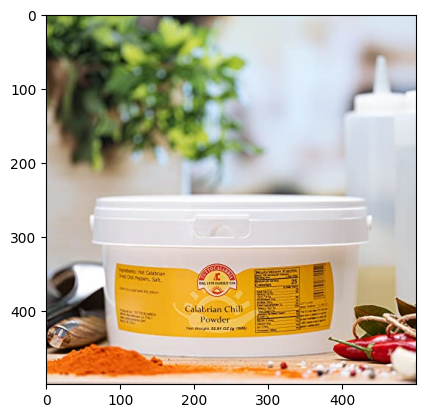

500.0 gram


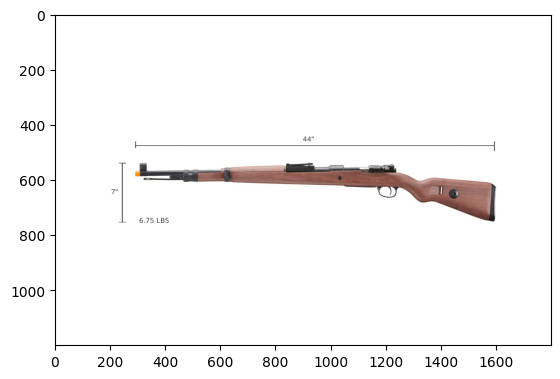

6.75 pound


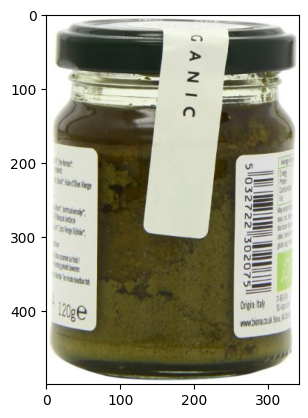

120.0 gram


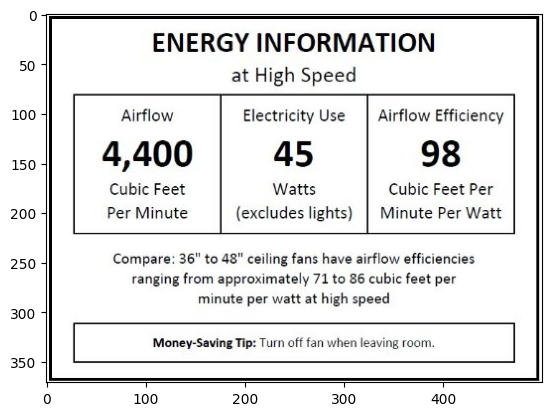

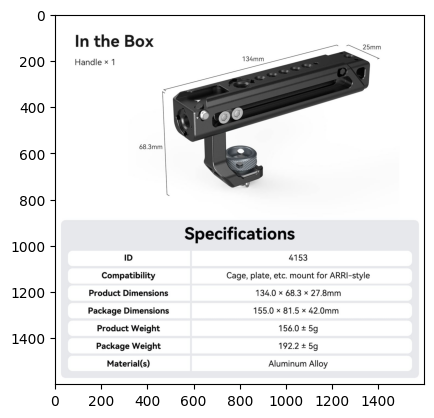

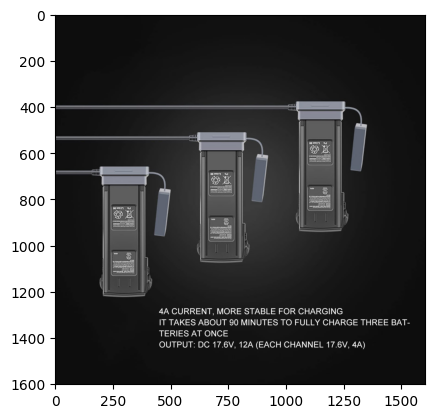

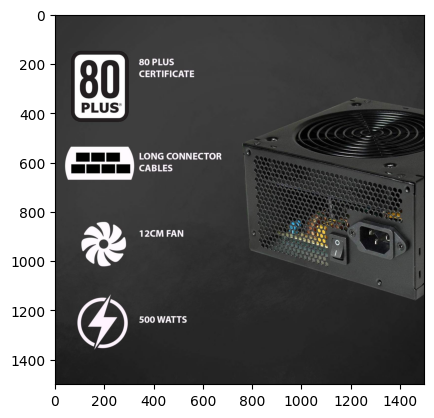

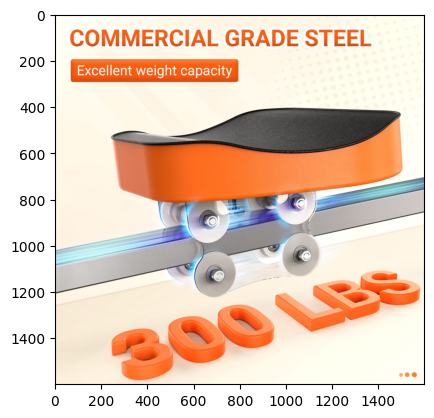

300.0 pound


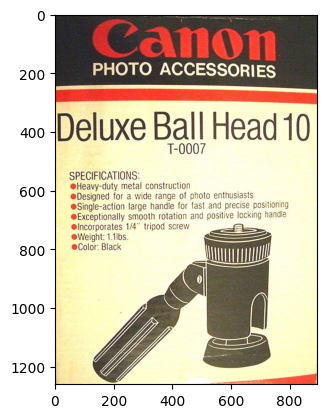

1.1 pound


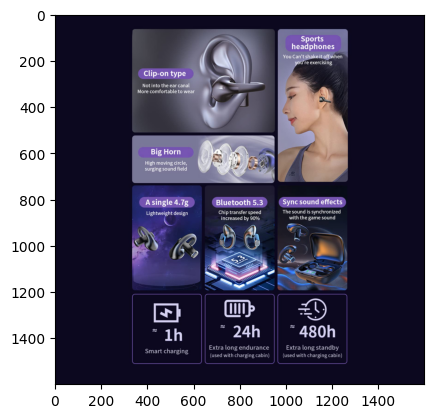

4.7 gram


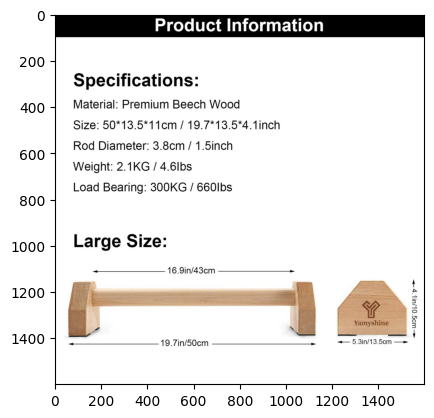

2.1 kilogram


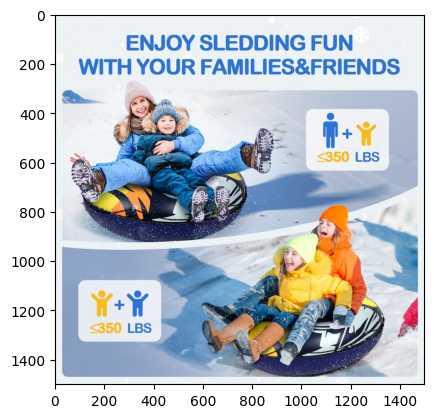

350.0 pound


In [ ]:
results = []
for i in range(len(test_images)):
  results.append(pipeline(test_images[i]))

In [ ]:
image = Image.open(requests.get(weight_images[10], stream=True).raw).convert('RGB')
results =  run_example('<OCR_WITH_REGION>' , image)
text = " ".join(results['<OCR_WITH_REGION>']['labels'])
print(text)

</s>WILDFANG® XS S M L XL 1,3 cm 2 cm 2,5 cm 3 cm 3,5cm 12 cm 13 cm 14 cm 15 cm 16 cm <10 kg 10-15 kg 15-25 kg 25-45 kg > 45 kg


In [ ]:
doc = nlp(text)

In [ ]:
" ".join(results['<OCR_WITH_REGION>']['labels'])

'</s>44" 7" 6.75 LBS'

In [ ]:
metric_pattern = r'(\d+(?:\.\d+)?(?:\s*[-–\/"]\s*\d+(?:\.\d+)?)?\s*(?:kg|g|mg|lbs|oz|ml|l|cm|mm|m|cup|"))'

attributes_metrics = extract_attributes_and_metrics(doc, metric_pattern)
ner_results = apply_ner_to_attributes(attributes_metrics)

In [ ]:
results

['500.0 gram',
 '6.75 pound',
 '120.0 gram',
 None,
 None,
 None,
 None,
 '300.0 pound',
 '1.1 pound',
 '4.7 gram',
 '2.1 kilogram',
 '350.0 pound']

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
height_images = df.groupby("entity_name")["image_link"].apply(list).to_dict()['height']

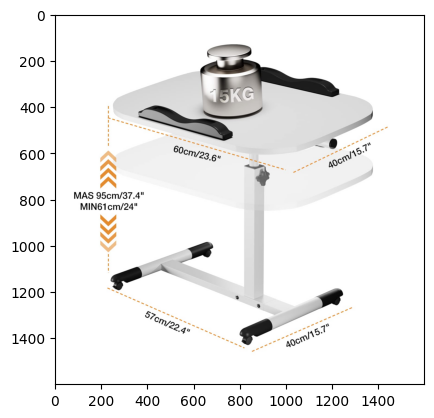

95 cm


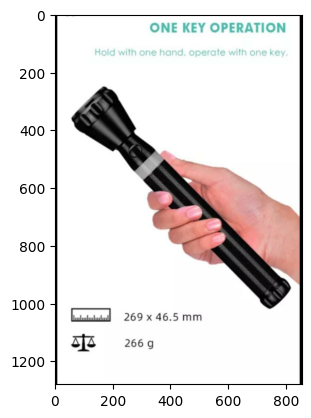

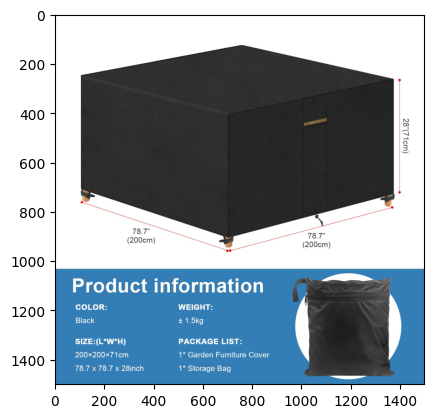

7.1 cm


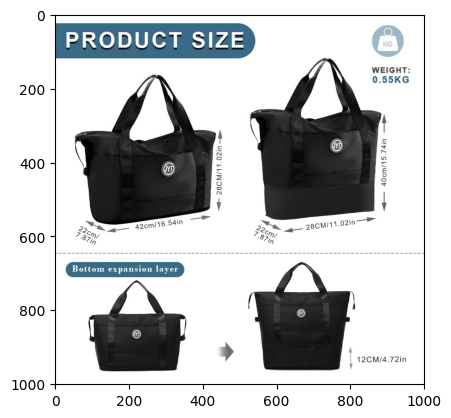

15.74 m


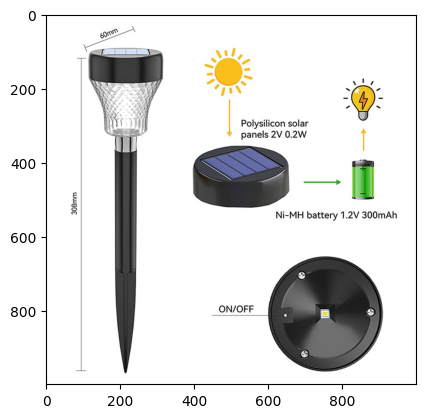

300 m


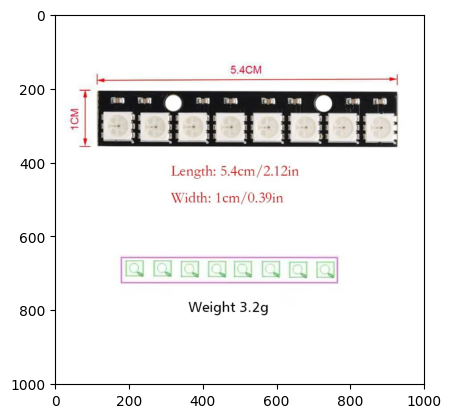

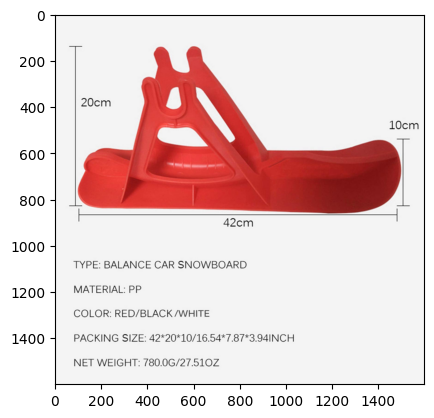

10 cm


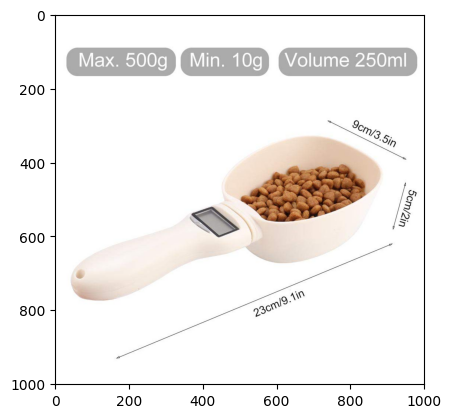

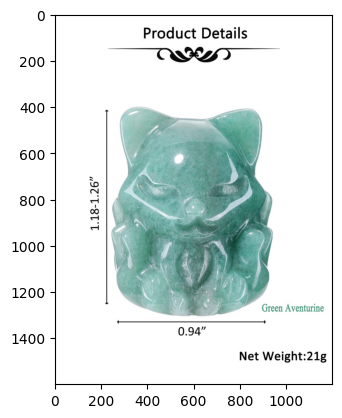

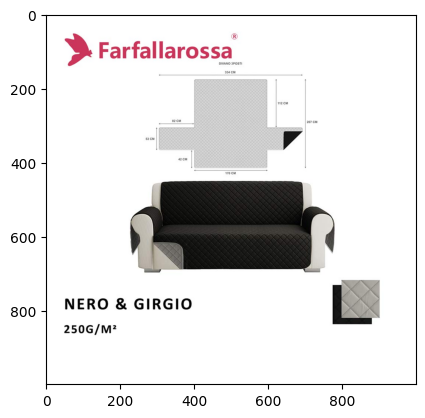

207 cm


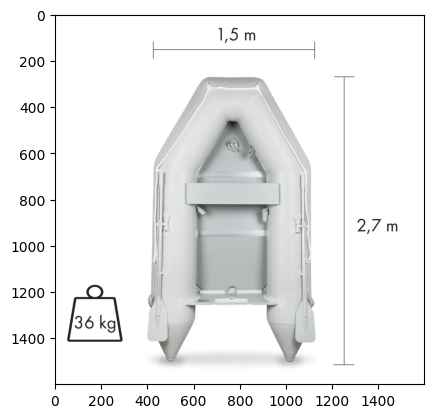

KeyboardInterrupt: 

In [ ]:
results = []
for i in range(20):
  results.append(pipeline2(height_images[i]))

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()